In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Different Approximations of Matérn Kernels on $\mathrm{SPD}(2)$ 

This notebooks compares two different approximations of the heat kernel (Matérn-$\infty$) on the manifold of Symmetric Positive-Definite Matrices $\mathrm{SPD}(2)$.

We use numpy for the computations and matplotlib for vizualization.

<!--TABLE OF CONTENTS-->
## Contents
  - [Introduction](#Introduction)
  - [Instantiate space and kernel](#Instantiate-space-and-kernel)
  - [Plot kernel values along a geodesic](#Plot-kernel-values-along-a-geodesic)
  - [Rejection sampling feature map/kernel](#Rejection-sampling-feature-map/kernel)
- [**Citation**](#Citation)

### Introduction

We employ the kernel defined by the _random phase features_. A complete mathematical treatise can be found in [Citation](#Citation). For the purposes of this notebook, it suffices to say that on noncompact symmetric spaces (of which the SPD space is a fine specimen), the kernel is defined in terms of an intractable integral over a probability density (called the *spectral density*). To approximate the integral, we use Monte Carlo sampling from the spectral density.

This is in contrast to _compact_ spaces (which we call `DiscreteSpectrumSpace`s), where the kernel is a sum of a _series_, that can be approximated via truncation.

On the SPD space, there are several methods for sampling from the spectral density. We will investigate them in this notebook.

For practical purposes, we just have to define a number of _random phases_ (the more we define, the better the approximation and the more computation required), specify a feature map, and pass it to the `MaternFeatureMapKernel`. The kernel requires a `key` to instantiate randomness in the _random phases_, and is a **deterministic** function.

In [1]:
from geometric_kernels.kernels import MaternFeatureMapKernel
from geometric_kernels.feature_maps import RandomPhaseFeatureMapNoncompact, RejectionSamplingFeatureMapSPD
from geometric_kernels.spaces.spd import SymmetricPositiveDefiniteMatrices

import geomstats.visualization as visualization
import matplotlib.pyplot as plt
import numpy as np

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


### Instantiate space and kernel



In the numpy world, the `key` is the `np.random.RandomState`:

In [2]:
_num_random_phases = 5_000

In [3]:
key = np.random.RandomState(seed=1234)

In [4]:
spd = SymmetricPositiveDefiniteMatrices(n=2)
feature_map = RandomPhaseFeatureMapNoncompact(spd, num_random_phases=_num_random_phases)
kernel = MaternFeatureMapKernel(spd, feature_map, key)

params = kernel.init_params()
params["nu"] = np.array([np.inf])
params["lengthscale"] = np.array([0.1])

### Plot kernel values along a geodesic

Let's plot kernel values `K(x, y)` where `y` runs the geodesic between `base` and `end_point`.

In [5]:
base = np.eye(2)
end_point = np.r_[1.0, 0.5, 0.5, 1.0].reshape(2,2)

geodesic = spd.metric.geodesic(initial_point=base, end_point=end_point)
x1 = geodesic(np.linspace(0.0, 1.0, 30))
x2 = x1[0, None]

distances = spd.metric.dist(x1, x2)

In [6]:
kernel_vals = kernel.K(params, x1, x2)

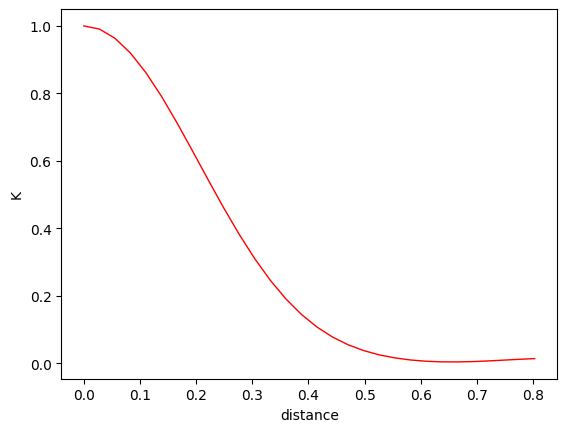

In [7]:
plt.plot(distances, kernel_vals, color="red", linewidth=1)
plt.xlabel('distance')
plt.ylabel('K')
plt.show()

### Rejection sampling feature map/kernel

Let's investigate the behaviour of another feature map defined on the SPD space. The feature map uses a specific form that the spectral density has in the SPD space, and samples from the spectral density using rejection sampling.

In the limit, when `_num_random_phases` tends to infinity, both feature maps give the same kernel. In order to contrast the two, we call the previous one "naive sampling based".

The math can be found in [1].

In [8]:
feature_map_rs = RejectionSamplingFeatureMapSPD(spd, num_random_phases=_num_random_phases)

In [9]:
kernel_rs = MaternFeatureMapKernel(spd, feature_map_rs, key)

In [10]:
kernel_vals_rs = kernel_rs.K(params, x1, x2)

Let's compare the two feature maps. They should be pretty close.

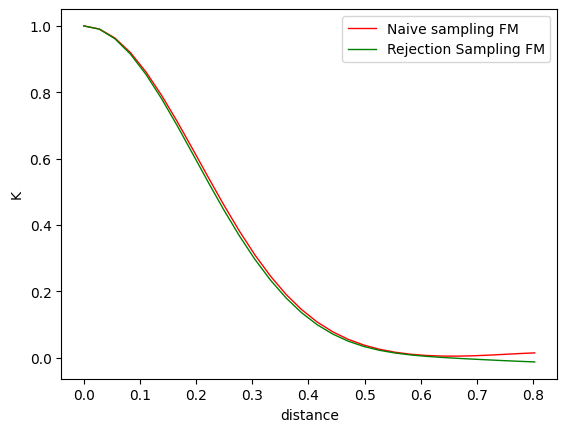

In [11]:
plt.plot(distances, kernel_vals, color="red", linewidth=1, label='Naive sampling FM')
plt.plot(distances, kernel_vals_rs, color="green", linewidth=1, label='Rejection Sampling FM')
plt.xlabel('distance')
plt.ylabel('K')
plt.legend()
plt.show()

Let's plot the convergence of the naive and rejection-sampling based approaches, as we construct more and more feature maps.

In [12]:
_num_phases = np.linspace(10, 3000, 20).astype(int)

In [13]:
naive_feature_maps = [RandomPhaseFeatureMapNoncompact(spd, num_random_phases=n) for n in _num_phases]
rs_feature_maps = [RejectionSamplingFeatureMapSPD(spd, num_random_phases=n) for n in _num_phases]

In [14]:
naive_kernels = [MaternFeatureMapKernel(spd, fm, key) for fm in naive_feature_maps]
rs_kernels = [MaternFeatureMapKernel(spd, fm, key) for fm in rs_feature_maps]


Let's evaluate the kernels on the same set of points, effectively getting two sequences of vectors.

To evaluate the convergence, we are going to compute the $L_2$-distances of the subsequent vectors.

In [15]:
naive_kernels_vals = [k.K(params, x1, x2) for k in naive_kernels]
rs_kernels_vals = [k.K(params, x1, x2) for k in rs_kernels]

In [16]:
naive_diffs = np.diff(naive_kernels_vals, axis=0)
rs_diffs = np.diff(rs_kernels_vals, axis=0)

naive_l2s = np.sqrt(np.sum(naive_diffs**2, axis=1))
rs_l2s = np.sqrt(np.sum(rs_diffs**2, axis=1))

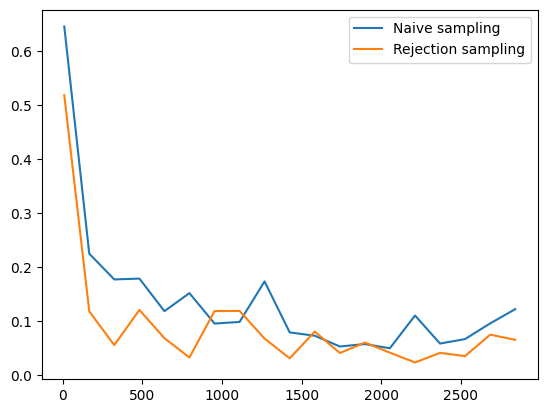

In [17]:
plt.plot(_num_phases[:-1], naive_l2s.ravel(), label='Naive sampling')
plt.plot(_num_phases[:-1], rs_l2s.ravel(), label='Rejection sampling')
plt.legend()
plt.show()
plt.show()

The rejection sampling based kernels show a better rate of convergence.

To illustrate this further, plot the kernel values for all the kernels we have computed. 

The rejection sampling based kernels values are more concentrated around the true kernel, 
whereas the naive sampling based kernels show higher distortion.

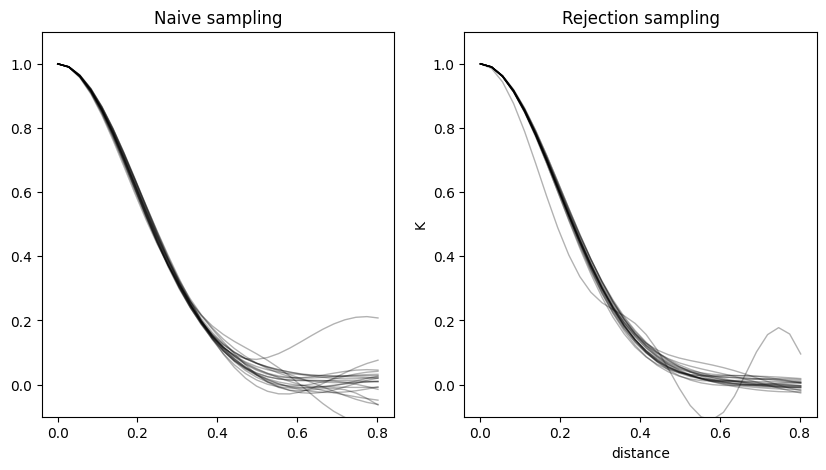

In [18]:
plt.figure(figsize=(10, 5))
for nf, naive_v, rs_v in zip(_num_phases, naive_kernels_vals, rs_kernels_vals):
    plt.subplot(121)
    plt.plot(distances, naive_v, linewidth=1, c='k', alpha=0.3)
    plt.subplot(122)
    plt.plot(distances, rs_v, linewidth=1, c='k', alpha=0.3)

plt.subplot(121)
plt.title('Naive sampling')
plt.ylim(-0.1, 1.1)
plt.subplot(122)
plt.title('Rejection sampling')
plt.ylim(-0.1, 1.1)
plt.xlabel('distance')
plt.ylabel('K')
plt.show()

That said, the rejection sampling might require more compute. It is up to a practioner to decide what type of kernel works best for the task at hand.

## Citation

If you are using GeometricKernels and manifolds of symmetric positive matrices, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@article{azangulov2024b,
  title = {Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
  author = {Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
  journal = {Journal of Machine Learning Research},
  year = {2024},
  volume = {25},
  number = {281},
  pages = {1--51},
}
```